# Validity of using prescription records to identify patient comorbidities
## Analysis of heart failure

**ReadMe:**
- This is a script used in the analysis for Schnier et al., 2025: Validity of using prescription records to classify disease – a record linkage study using routinely collected electronic health records from the UK.
- The underlying data set has been created using the Optimum Patient Care Research Database (https://opcrd.optimumpatientcare.org/). The authors do not have permission to give the public access to the study dataset; researchers may request access to OPCRD for their own purposes. 
 - All code is run in StataSE 18. 


**Set up:**
|Var|Input|
| --- | --- | 
|population|425,000|
|diagnostic codes|open codelist for snomed; hdruk for readv2|
|drug codes|bnf selection|
|sql date|14.03.2025|
|sql code|chfselection20250313.sql| 

In [1]:
    clear all

### Import from SQL server and data wrangling

In [2]:
odbc load, exec("select * from [chf_425000_20250313]") dsn("sqlserverconnect")

In [3]:
generate test=0 if missing(drug_dt)
replace test=1 if ! missing(drug_dt)  

generate diag=0 if missing(diag_dt)
replace diag=1 if ! missing(diag_dt)  

gen start_year=year(fu_start_dt)


egen agecat = cut(age), at(16,30,70,120)
label def agecat_lab 16 "Young" 30 "0Middle" 70 "Elderly" 120 "weird"
label values agecat agecat_lab

egen yearcat = cut(start_year), at(2004,2010,2016,2025)
label def yearcat_lab 2004 "2004-2009" 2010 "2010-2015" 2016 "2016-2020" 
label values yearcat yearcat_lab

egen imdcat = cut(imd_decile), at(0,4,8,11)
label def imdcat_lab 0 "1-3" 4 "4-7" 8 "8-10" 
label values imdcat imdcat_lab


replace bnf_code = "Thiazides and related diuretics" if bnf_code== "020201"
replace bnf_code = "Loop diuretics" if bnf_code== "020202"
replace bnf_code = "Potassium sparing diuretics" if bnf_code== "020203"
replace bnf_code = "Potassium sparing diuretics plus other" if bnf_code== "020204"
replace bnf_code = "Drugs affecting resin-angiotensin system"  if bnf_code== "020505"
replace bnf_code = "Diuretics with potassium"  if bnf_code== "020208"
replace bnf_code = "Other/unknown" if missing(bnf_code) & ! missing(drug_dt)
replace bnf_code = "Other/unknown" if substr(bnf_code,1,1) =="0" | substr(bnf_code,1,1) =="1" 



replace ethnicity="0white" if ethnicity=="1"
replace ethnicity="Other" if ethnicity=="2"
replace ethnicity="Other" if ethnicity=="3"
replace ethnicity="Other" if ethnicity=="4"
replace ethnicity="Other" if ethnicity=="5"
replace ethnicity="Missing" if ethnicity=="99"


encode bnf_code, generate(bnf_code_values) 
encode description, generate(description_values)
encode ethnicity, generate(ethnicity_values) 

gen diag_neg=diag==0
gen diag_pos=diag==1
encode region_name, generate(region) label(regionlbl)
encode ethnicity, generate(ethnic)


(85,053 missing values generated)
(85,053 real changes made)
(7,488 missing values generated)
(7,488 real changes made)
(2,589 missing values generated)
variable bnf_code was str6 now str31
(14,118 real changes made)
(15,991 real changes made)
(1,832 real changes made)
variable bnf_code was str31 now str38
(1,296 real changes made)
variable bnf_code was str38 now str40
(51,608 real changes made)
(25 real changes made)
(154 real changes made)
(29 real changes made)
variable ethnicity was str2 now str6
(257,981 real changes made)
(3,762 real changes made)
(23,912 real changes made)
(7,430 real changes made)
(8,764 real changes made)
variable ethnicity was str6 now str7
(123,151 real changes made)


(bin=19, start=16, width=5)


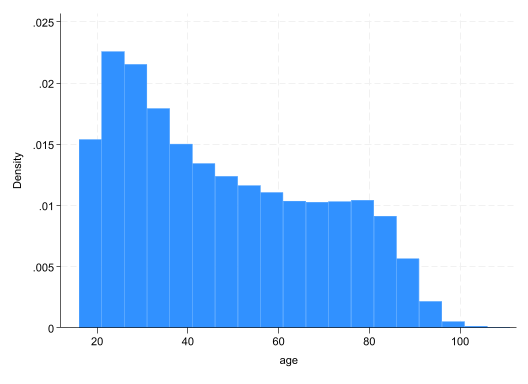

In [4]:
histogram age, width(5)


This table holds one randomly selected diagnostic code found during the observation period. The table is truncated to only include diagnostic codes with a count of 10 or more.

In [5]:
set linesize 132
groups description , select(f >= 10) ord(h) table 


  +----------------------------------------------------------------------------------------+
  |                                                  description   Freq.   Percent     %<= |
  |----------------------------------------------------------------------------------------|
  |                                                Heart failure    1749     23.36   23.36 |
  |                       Heart failure: [right] or [congestive]     451      6.02   29.38 |
  |   Echocardiogram shows left ventricular systolic dysfunction     416      5.56   34.94 |
  |                        Left ventricular systolic dysfunction     405      5.41   40.34 |
  |                           Impaired left ventricular function     373      4.98   45.33 |
  |----------------------------------------------------------------------------------------|
  | (L ventric:[fail][imp func]) or (card asth) or (ac pulm oed)     348      4.65   49.97 |
  |                                           Left heart failure     

These tables holds one randomly selected prescrption during the observation period. The table is truncated to only include codes with a count of 10 or more.


In [6]:
set linesize 132
groups bnf_code , select(f >= 10) ord(h) table 


  +---------------------------------------------------------------------+
  |                                 bnf_code   Freq.   Percent      %<= |
  |---------------------------------------------------------------------|
  | Drugs affecting resin-angiotensin system   51608     60.68    60.68 |
  |                           Loop diuretics   15991     18.80    79.48 |
  |          Thiazides and related diuretics   14118     16.60    96.08 |
  |              Potassium sparing diuretics    1832      2.15    98.23 |
  |   Potassium sparing diuretics plus other    1296      1.52    99.76 |
  |---------------------------------------------------------------------|
  |                            Other/unknown     183      0.22    99.97 |
  |                 Diuretics with potassium      25      0.03   100.00 |
  +---------------------------------------------------------------------+


### Results
#### Overall

In [7]:
diagt diag test


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     7,093        395 |     7,488 
    Normal |    77,960    339,552 |   417,512 
-----------+----------------------+----------
     Total |    85,053    339,947 |   425,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.8%      1.7%       1.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.7%     94.2%     95.2%
Specificity                      Pr(-|N)     81.3%     81.2%     81.4%
ROC area               (Sens. + Spec.)/2      0.88      0.88      0.88 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.07      5.

#### Males

In [8]:
diagt diag test if sex==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,856        211 |     4,067 
    Normal |    37,165    167,053 |   204,218 
-----------+----------------------+----------
     Total |    41,021    167,264 |   208,285 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.0%      1.9%       2.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.8%     94.1%     95.5%
Specificity                      Pr(-|N)     81.8%     81.6%     82.0%
ROC area               (Sens. + Spec.)/2      0.88      0.88      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.21      5.

#### Females

In [9]:
diagt diag test if sex==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     3,237        184 |     3,421 
    Normal |    40,795    172,490 |   213,285 
-----------+----------------------+----------
     Total |    44,032    172,674 |   216,706 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.6%      1.5%       1.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.6%     93.8%     95.4%
Specificity                      Pr(-|N)     80.9%     80.7%     81.0%
ROC area               (Sens. + Spec.)/2      0.88      0.87      0.88 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.95      4.

#### Age
*16-29*

In [10]:
diagt diag test if agecat==16


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |        20          6 |        26 
    Normal |       647    117,001 |   117,648 
-----------+----------------------+----------
     Total |       667    117,007 |   117,674 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.0%      0.0%       0.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     76.9%     56.4%     91.0%
Specificity                      Pr(-|N)     99.5%     99.4%     99.5%
ROC area               (Sens. + Spec.)/2      0.88      0.80      0.96 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)    139.87    111.

*30-69*

In [11]:
diagt diag test if agecat==30


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,567        130 |     1,697 
    Normal |    33,195    186,503 |   219,698 
-----------+----------------------+----------
     Total |    34,762    186,633 |   221,395 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.8%      0.7%       0.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.3%     91.0%     93.6%
Specificity                      Pr(-|N)     84.9%     84.7%     85.0%
ROC area               (Sens. + Spec.)/2      0.89      0.88      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.11      6.

In [12]:
diagt diag test if agecat==70


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     5,506        259 |     5,765 
    Normal |    44,118     36,048 |    80,166 
-----------+----------------------+----------
     Total |    49,624     36,307 |    85,931 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      6.7%      6.5%       6.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.5%     94.9%     96.0%
Specificity                      Pr(-|N)     45.0%     44.6%     45.3%
ROC area               (Sens. + Spec.)/2      0.70      0.70      0.71 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      1.74      1.

#### Year at start of oberservation period 
*2004-2009*

In [13]:
diagt diag test if yearcat==2004


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,545         64 |     2,609 
    Normal |    34,159    113,232 |   147,391 
-----------+----------------------+----------
     Total |    36,704    113,296 |   150,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.7%      1.7%       1.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     97.5%     96.9%     98.1%
Specificity                      Pr(-|N)     76.8%     76.6%     77.0%
ROC area               (Sens. + Spec.)/2      0.87      0.87      0.88 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.21      4.

*2010-2015*

In [14]:
diagt diag test if yearcat==2010


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,103        104 |     2,207 
    Normal |    26,695    121,098 |   147,793 
-----------+----------------------+----------
     Total |    28,798    121,202 |   150,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.5%      1.4%       1.5%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.3%     94.3%     96.1%
Specificity                      Pr(-|N)     81.9%     81.7%     82.1%
ROC area               (Sens. + Spec.)/2      0.89      0.88      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.28      5.

*2016-2020*

In [15]:
diagt diag test if yearcat==2016


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,445        227 |     2,672 
    Normal |    17,106    105,222 |   122,328 
-----------+----------------------+----------
     Total |    19,551    105,449 |   125,000 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.1%      2.1%       2.2%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     91.5%     90.4%     92.5%
Specificity                      Pr(-|N)     86.0%     85.8%     86.2%
ROC area               (Sens. + Spec.)/2      0.89      0.88      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.54      6.

#### IMD of practice
*1-3*

In [16]:
diagt diag test if imdcat==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,384        136 |     2,520 
    Normal |    26,742    125,289 |   152,031 
-----------+----------------------+----------
     Total |    29,126    125,425 |   154,551 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.6%      1.6%       1.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.6%     93.6%     95.5%
Specificity                      Pr(-|N)     82.4%     82.2%     82.6%
ROC area               (Sens. + Spec.)/2      0.89      0.88      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.38      5.

*4-7*

In [17]:
diagt diag test if imdcat==4


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,606        133 |     2,739 
    Normal |    28,706    111,600 |   140,306 
-----------+----------------------+----------
     Total |    31,312    111,733 |   143,045 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.9%      1.8%       2.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.1%     94.3%     95.9%
Specificity                      Pr(-|N)     79.5%     79.3%     79.8%
ROC area               (Sens. + Spec.)/2      0.87      0.87      0.88 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.65      4.

*8-10*

In [18]:
diagt diag test if imdcat==8


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,098        126 |     2,224 
    Normal |    22,441    100,150 |   122,591 
-----------+----------------------+----------
     Total |    24,539    100,276 |   124,815 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.8%      1.7%       1.9%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.3%     93.3%     95.3%
Specificity                      Pr(-|N)     81.7%     81.5%     81.9%
ROC area               (Sens. + Spec.)/2      0.88      0.88      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.15      5.

#### Commissioning Regions
EAST OF ENGLAND

In [19]:
diagt diag test if regexm(region_name,"ENGLAND")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,509         67 |     1,576 
    Normal |    18,654     69,407 |    88,061 
-----------+----------------------+----------
     Total |    20,163     69,474 |    89,637 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.8%      1.7%       1.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.7%     94.6%     96.7%
Specificity                      Pr(-|N)     78.8%     78.5%     79.1%
ROC area               (Sens. + Spec.)/2      0.87      0.87      0.88 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.52      4.

London

In [20]:
diagt diag test if regexm(region_name,"LONDON")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       148         13 |       161 
    Normal |     1,342     15,222 |    16,564 
-----------+----------------------+----------
     Total |     1,490     15,235 |    16,725 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.0%      0.8%       1.1%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     91.9%     86.6%     95.6%
Specificity                      Pr(-|N)     91.9%     91.5%     92.3%
ROC area               (Sens. + Spec.)/2      0.92      0.90      0.94 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)     11.35     10.

Midlands

In [21]:
diagt diag test if regexm(region_name,"MID")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,007         54 |     1,061 
    Normal |     9,756     35,726 |    45,482 
-----------+----------------------+----------
     Total |    10,763     35,780 |    46,543 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.3%      2.1%       2.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.9%     93.4%     96.2%
Specificity                      Pr(-|N)     78.5%     78.2%     78.9%
ROC area               (Sens. + Spec.)/2      0.87      0.86      0.87 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.42      4.

Yorkshire

In [22]:
diagt diag test if regexm(region_name,"YORK")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,558         93 |     1,651 
    Normal |    15,394     69,066 |    84,460 
-----------+----------------------+----------
     Total |    16,952     69,159 |    86,111 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.9%      1.8%       2.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.4%     93.1%     95.4%
Specificity                      Pr(-|N)     81.8%     81.5%     82.0%
ROC area               (Sens. + Spec.)/2      0.88      0.87      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.18      5.

North West

In [23]:
diagt diag test if regexm(region_name,"NORTH")==1 & regexm(region_name,"WEST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       731         46 |       777 
    Normal |     6,929     39,887 |    46,816 
-----------+----------------------+----------
     Total |     7,660     39,933 |    47,593 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.6%      1.5%       1.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.1%     92.2%     95.6%
Specificity                      Pr(-|N)     85.2%     84.9%     85.5%
ROC area               (Sens. + Spec.)/2      0.90      0.89      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      6.36      6.

South East

In [24]:
diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"EAST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,252         77 |     1,329 
    Normal |    15,210     73,946 |    89,156 
-----------+----------------------+----------
     Total |    16,462     74,023 |    90,485 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.5%      1.4%       1.5%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.2%     92.8%     95.4%
Specificity                      Pr(-|N)     82.9%     82.7%     83.2%
ROC area               (Sens. + Spec.)/2      0.89      0.88      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.52      5.

South West

In [25]:
diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"WEST")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       728         38 |       766 
    Normal |     8,553     26,857 |    35,410 
-----------+----------------------+----------
     Total |     9,281     26,895 |    36,176 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.1%      2.0%       2.3%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.0%     93.3%     96.5%
Specificity                      Pr(-|N)     75.8%     75.4%     76.3%
ROC area               (Sens. + Spec.)/2      0.85      0.85      0.86 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      3.93      3.

#### System
SystmOne

In [26]:
diagt diag test if regexm(system,"One")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     4,196        226 |     4,422 
    Normal |    46,594    177,739 |   224,333 
-----------+----------------------+----------
     Total |    50,790    177,965 |   228,755 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.9%      1.9%       2.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.9%     94.2%     95.5%
Specificity                      Pr(-|N)     79.2%     79.1%     79.4%
ROC area               (Sens. + Spec.)/2      0.87      0.87      0.87 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.57      4.

Vision

In [27]:
diagt diag test if regexm(system,"Vision")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       197          9 |       206 
    Normal |     2,662     10,876 |    13,538 
-----------+----------------------+----------
     Total |     2,859     10,885 |    13,744 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.5%      1.3%       1.7%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.6%     91.9%     98.0%
Specificity                      Pr(-|N)     80.3%     79.7%     81.0%
ROC area               (Sens. + Spec.)/2      0.88      0.87      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.86      4.

EMIS

In [28]:
diagt diag test if regexm(ustrupper(system),"EMIS")==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     2,700        160 |     2,860 
    Normal |    28,653    150,852 |   179,505 
-----------+----------------------+----------
     Total |    31,353    151,012 |   182,365 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.6%      1.5%       1.6%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.4%     93.5%     95.2%
Specificity                      Pr(-|N)     84.0%     83.9%     84.2%
ROC area               (Sens. + Spec.)/2      0.89      0.89      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.91      5.

#### RA_Index
Index==1

In [29]:
diagt diag test if RA_index==1


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     5,441        314 |     5,755 
    Normal |    57,185    258,757 |   315,942 
-----------+----------------------+----------
     Total |    62,626    259,071 |   321,697 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.8%      1.7%       1.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.5%     93.9%     95.1%
Specificity                      Pr(-|N)     81.9%     81.8%     82.0%
ROC area               (Sens. + Spec.)/2      0.88      0.88      0.89 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.22      5.

Index==0

In [30]:
diagt diag test if RA_index==0


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,652         81 |     1,733 
    Normal |    20,775     80,795 |   101,570 
-----------+----------------------+----------
     Total |    22,427     80,876 |   103,303 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.7%      1.6%       1.8%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.3%     94.2%     96.3%
Specificity                      Pr(-|N)     79.5%     79.3%     79.8%
ROC area               (Sens. + Spec.)/2      0.87      0.87      0.88 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.66      4.

#### Ethnicity
Ethnicity==0000white

In [31]:
diagt diag test if ethnicity=="0white"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     5,177        298 |     5,475 
    Normal |    53,621    198,885 |   252,506 
-----------+----------------------+----------
     Total |    58,798    199,183 |   257,981 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      2.1%      2.1%       2.2%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     94.6%     93.9%     95.1%
Specificity                      Pr(-|N)     78.8%     78.6%     78.9%
ROC area               (Sens. + Spec.)/2      0.87      0.86      0.87 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      4.45      4.

In [32]:
diagt diag test if ethnicity=="Other"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |       364         31 |       395 
    Normal |     4,624     38,849 |    43,473 
-----------+----------------------+----------
     Total |     4,988     38,880 |    43,868 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      0.9%      0.8%       1.0%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     92.2%     89.0%     94.6%
Specificity                      Pr(-|N)     89.4%     89.1%     89.7%
ROC area               (Sens. + Spec.)/2      0.91      0.89      0.92 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      8.66      8.

In [33]:
diagt diag test if ethnicity=="Missing"


           |         test
      diag |      Pos.       Neg. |     Total
-----------+----------------------+----------
  Abnormal |     1,552         66 |     1,618 
    Normal |    19,715    101,818 |   121,533 
-----------+----------------------+----------
     Total |    21,267    101,884 |   123,151 
True abnormal diagnosis defined as diag = 1


                                                  [95% Confidence Interval]
---------------------------------------------------------------------------
Prevalence                         Pr(A)      1.3%      1.3%       1.4%
---------------------------------------------------------------------------
Sensitivity                      Pr(+|A)     95.9%     94.8%     96.8%
Specificity                      Pr(-|N)     83.8%     83.6%     84.0%
ROC area               (Sens. + Spec.)/2      0.90      0.89      0.90 
---------------------------------------------------------------------------
Likelihood ratio (+)     Pr(+|A)/Pr(+|N)      5.91      5.

In [34]:
tempname memhold
postfile `memhold' str20 var prev sens spec ppv npv roc using "validity.dta",replace

quietly diagt diag test
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("all") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if sex==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Male") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if sex==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Female") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==16
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age young") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==30
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age middle") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if agecat==70
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Age elderly") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if yearcat==2004
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2004-2009") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if yearcat==2010
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2010-2015") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc')

quietly diagt diag test if yearcat==2016
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Year 2016-2020") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if imdcat==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 1,3") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if imdcat==4
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 4,7") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if imdcat==8
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("IMD 8,10") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 


quietly diagt diag test if regexm(region_name,"LONDON")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("London") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"MID")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Midlands") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"YORK")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Yorkshire") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"NORTH")==1 & regexm(region_name,"WEST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("North West") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"EAST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("South East") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(region_name,"SOUTH")==1 & regexm(region_name,"WEST")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("South West") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(system,"One")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("SystemOne") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(system,"Vision")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Vision") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if regexm(ustrupper(system),"EMIS")==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("EMIS") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if RA_index==1
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("RAIndex1") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if RA_index==0
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("RAIndex0") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if ethnicity=="0white"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_0white") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

quietly diagt diag test if ethnicity=="Other"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_Other") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 



quietly diagt diag test if ethnicity=="Missing"
local prev=r(prev)
local sens=r(sens)
local spec=r(spec)
local ppv=r(ppv)
local npv=r(npv)
local roc=r(roc)
post `memhold' ("Ethnicity_Missing") (`prev') (`sens') (`spec') (`ppv') (`npv') (`roc') 

postclose `memhold'

### Logistic Regression
#### PPV

In [35]:
drop if missing(imdcat)
drop if missing(sex)

(2,589 observations deleted)
(9 observations deleted)


In [36]:
logistic diag_pos if test==1


Logistic regression                                     Number of obs = 84,977
                                                        LR chi2(0)    =   0.00
                                                        Prob > chi2   =      .
Log likelihood = -24390.244                             Pseudo R2     = 0.0000

------------------------------------------------------------------------------
    diag_pos |       Odds   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _cons |   .0910013    .001129  -193.19   0.000     .0888152    .0932412
------------------------------------------------------------------------------


In [37]:
gen newdiag=diag_pos

melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model1


Fitting fixed-effects model:

Iteration 0:  Log likelihood = -24193.661  
Iteration 1:  Log likelihood = -23190.698  
Iteration 2:  Log likelihood = -23186.236  
Iteration 3:  Log likelihood = -23186.232  
Iteration 4:  Log likelihood = -23186.232  

Refining starting values:

Grid node 0:  Log likelihood = -23268.678

Fitting full model:

Iteration 0:  Log likelihood = -23268.678  (not concave)
Iteration 1:  Log likelihood = -23194.924  (not concave)
Iteration 2:  Log likelihood = -23124.064  
Iteration 3:  Log likelihood = -23106.682  
Iteration 4:  Log likelihood = -23104.795  
Iteration 5:  Log likelihood = -23104.683  
Iteration 6:  Log likelihood = -23104.683  

Mixed-effects logistic regression               Number of obs     =     84,669
Group variable: practice_id                     Number of groups  =        327

                                                Obs per group:
                                                              min =          1
                     

##### Likelihood ratio tests

In [38]:


quietly: melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.ethnic if test==1 || practice_id:,or
estimates store model_imd

quietly:melogit newdiag i.sex i.yearcat i.agecat  i.region RA_index i.imdcat if test==1 || practice_id:,or
estimates store model_ethnicity

quietly:melogit newdiag i.yearcat i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_sex

quietly:melogit newdiag i.sex i.agecat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_year

quietly: melogit newdiag i.sex i.yearcat  i.region RA_index i.ethnic i.imdcat if test==1 || practice_id:,or
estimates store model_age



In [39]:
lrtest model1 model_sex
lrtest model1 model_year
lrtest model1 model_age
lrtest model1 model_ethnicity
lrtest model1 model_imd



Likelihood-ratio test
Assumption: model_sex nested within model1

 LR chi2(1) = 232.17
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_year nested within model1

 LR chi2(2) = 539.19
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model_age nested within model1

 LR chi2(2) = 1423.99
Prob > chi2 =  0.0000

Likelihood-ratio test
Assumption: model_ethnic~y nested within model1

 LR chi2(2) =   2.29
Prob > chi2 = 0.3177

Likelihood-ratio test
Assumption: model_imd nested within model1

 LR chi2(2) =   4.63
Prob > chi2 = 0.0987


#### NPV

In [40]:
logistic diag_neg if test==0


Logistic regression                                    Number of obs = 337,425
                                                       LR chi2(0)    =    0.00
                                                       Prob > chi2   =       .
Log likelihood = -3061.1028                            Pseudo R2     =  0.0000

------------------------------------------------------------------------------
    diag_neg |       Odds   Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
       _cons |   853.2405   42.95634   134.06   0.000     773.0681    941.7273
------------------------------------------------------------------------------


In [41]:
/* need to use the same response variable (newdiag) to line up the two model results */
replace newdiag=diag_neg 

melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2

(422,402 real changes made)

Fitting fixed-effects model:

Iteration 0:  Log likelihood =  -29468.43  
Iteration 1:  Log likelihood = -3068.1255  
Iteration 2:  Log likelihood = -2604.7504  
Iteration 3:  Log likelihood = -2566.9926  
Iteration 4:  Log likelihood = -2561.9978  
Iteration 5:  Log likelihood = -2561.8499  
Iteration 6:  Log likelihood = -2561.8498  

Refining starting values:

Grid node 0:  Log likelihood = -2585.1496

Fitting full model:

Iteration 0:  Log likelihood = -2585.1496  (not concave)
Iteration 1:  Log likelihood = -2558.6612  
Iteration 2:  Log likelihood = -2557.1819  
Iteration 3:  Log likelihood = -2556.9976  
Iteration 4:  Log likelihood =  -2556.997  
Iteration 5:  Log likelihood =  -2556.997  

Mixed-effects logistic regression               Number of obs     =    336,764
Group variable: practice_id                     Number of groups  =        337

                                                Obs per group:
                                         

##### Likelihood ratio tests

In [42]:

quietly: melogit newdiag i.yearcat i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_sex
quietly: melogit newdiag i.sex i.agecat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_year
quietly: melogit newdiag i.sex i.yearcat i.region RA_index i.ethnic i.imdcat if test==0 || practice_id:,or
estimates store model2_age
quietly: melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.imdcat if test==0 || practice_id:,or
estimates store model2_ethnicity
quietly: melogit newdiag i.sex i.yearcat i.agecat i.region RA_index i.ethnic if test==0 || practice_id:,or
estimates store model2_imd


In [43]:
lrtest model2 model2_sex
lrtest model2 model2_year
lrtest model2 model2_age
lrtest model2 model2_ethnicity
lrtest model2 model2_imd



Likelihood-ratio test
Assumption: model2_sex nested within model2

 LR chi2(1) =   9.59
Prob > chi2 = 0.0020

Likelihood-ratio test
Assumption: model2_year nested within model2

 LR chi2(2) = 134.50
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model2_age nested within model2

 LR chi2(2) = 807.47
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model2_ethni~y nested within model2

 LR chi2(2) =  20.66
Prob > chi2 = 0.0000

Likelihood-ratio test
Assumption: model2_imd nested within model2

 LR chi2(2) =   2.10
Prob > chi2 = 0.3491


In [44]:
etable, estimates(model1 model2) showstars showstarsnote title("Table 2. PPV (1) and NPV (2),  OR, Random effect") cstat(_r_b,nformat(%6.2f)) column(index) 


Table 2. PPV (1) and NPV (2), OR, Random effect
--------------------------------------------------------------------
                                                    1         2     
--------------------------------------------------------------------
sex_coded                                                           
  1                                              1.48 **     0.73 **
yearcat                                                             
  2010-2015                                      1.09 **     0.60 **
  2016-2020                                      2.03 **     0.23 **
agecat                                                              
  0Middle                                        1.57 *      0.07 **
  Elderly                                        4.55 **     0.01 **
region                                                              
  LONDON COMMISSIONING REGION                    1.37 *      0.80   
  MIDLANDS COMMISSIONING REGION                  1.30 

### Summary of validation parameters

In [45]:
use validity.dta, clear
replace prev=round(prev, 0.1)
gen prev_a=round(((prev/100)*((sens/100)+(spec/100)-1)+1-(spec/100))*100,0.1)/*apparent prevalence*/
replace sens=round(sens, 0.1)
replace spec=round(spec,0.1)
replace ppv=round(ppv, 0.1)
replace npv=round(npv, 0.1)
replace roc=round(roc, 0.01)


(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)
(26 real changes made)


In [46]:
%head 50

,var,prev,sens,spec,ppv,npv,roc,prev_a
1,all,1.8,94.7,81.3,8.3,99.9,.88,20
2,Male,2,94.8,81.8,9.4,99.9,.88,19.7
3,Female,1.6,94.6,80.9,7.4,99.9,.88,20.3
4,Age young,0,76.9,99.5,3,100,.88,.5
5,Age middle,.8,92.3,84.9,4.5,99.9,.89,15.7
6,Age elderly,6.7,95.5,45,11.1,99.3,.7,57.7
7,Year 2004-2009,1.7,97.5,76.8,6.9,99.9,.87,24.4
8,Year 2010-2015,1.5,95.3,81.9,7.3,99.9,.89,19.2
9,Year 2016-2020,2.1,91.5,86,12.5,99.8,.89,15.6
10,"IMD 1,3",1.6,94.6,82.4,8.2,99.9,.89,18.8


In [47]:
/*texsave * using test3.tex, varlabels*/
/*
export excel using  validity2.xlsx, sheet(val_thyroid, replace)
*/